In [2]:
import ast
import pandas as pd
import matplotlib.pyplot as plt

#Loading data
df = pd.read_csv("hf://datasets/lukebarousse/data_jobs/data_jobs.csv")

#Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
#converted to list
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

#Filter for Data Analyst Data
df_DA = df[df['job_title_short'] == 'Data Analyst'].copy()

Customizing our chart from 12_Exercise_Trending_Skills.ipynb

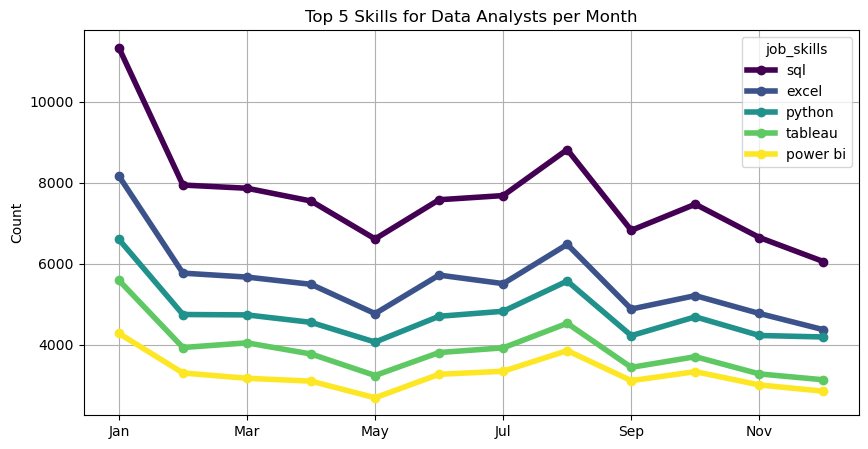

In [6]:
# create a new column for month number
df_DA['job_posted_month_no'] = df_DA['job_posted_date'].dt.month

# Explode the job_skills column and pivot
df_DA_explode= df_DA.explode('job_skills')
df_DA_pivot = df_DA_explode.pivot_table(index='job_posted_month_no', columns='job_skills',  aggfunc='size', fill_value=0)

# sort the skills by count
df_DA_pivot.loc['Total'] = df_DA_pivot.sum()
df_DA_pivot = df_DA_pivot[df_DA_pivot.loc['Total'].sort_values(ascending=False).index]
df_DA_pivot = df_DA_pivot.drop('Total')

# Use month names for plotting
df_DA_pivot = df_DA_pivot.reset_index()
df_DA_pivot['job_posted_month'] = df_DA_pivot['job_posted_month_no'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_DA_pivot = df_DA_pivot.set_index('job_posted_month')
df_DA_pivot = df_DA_pivot.drop(columns='job_posted_month_no')

# Get the top 5 skills
df_DA_pivot.iloc[:, :5].plot(kind='line',
    linewidth=4,
    linestyle='-', # options: '-', '--', '-.', ':'
    colormap='viridis', # options: 'viridis', 'plasma', 'inferno', 'magma', 'cividis' 
    markersize=6,
    marker='o', # options: 'o', 'x', '+', '*', 's', ',', '.', '1', '2', '3', '4', ...
    figsize=(10, 5))

plt.grid(True)
plt.title('Top 5 Skills for Data Analysts per Month')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

Customizing our Scatter plot from 15_Scatter_Plot.ipynb

In [9]:
# Explode the 'job_skills' into individual rows
df_exploded = df_DA.explode('job_skills')

# Calculate the average salary and count of job postings per skill
skill_stats = df_exploded.groupby('job_skills').agg(
    median_salary=('salary_year_avg', 'median'),
    skill_count=('job_skills', 'count')
)

# Limit to the top skills
skill_count = 20
skill_stats = skill_stats.sort_values(by='skill_count', ascending=False).head(skill_count)
skill_stats

,median_salary,skill_count
job_skills,,
sql,92500.000000,92428
excel,84479.000000,66860
python,98500.000000,57190
tableau,95000.000000,46455
power bi,90000.000000,39380
r,92527.500000,29996
sas,90000.000000,27998
powerpoint,85000.000000,13822
word,80000.000000,13562


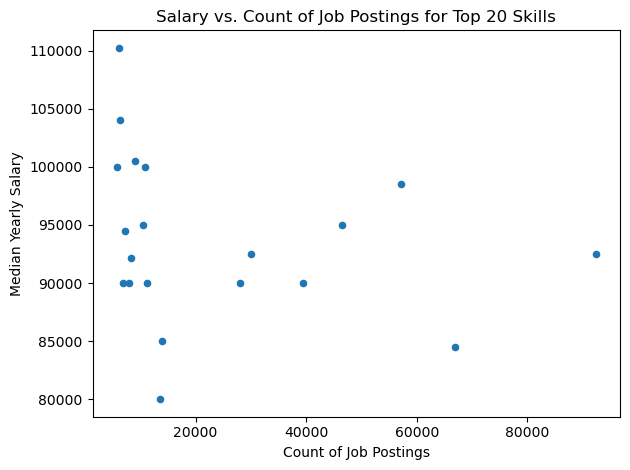

In [10]:
#Lets plot it
skill_stats.plot(kind='scatter', x='skill_count', y='median_salary')
plt.xlabel('Count of Job Postings')
plt.ylabel('Median Yearly Salary')
plt.title(f'Salary vs. Count of Job Postings for Top {skill_count} Skills')
plt.tight_layout()
plt.show()

Add Annotations

Text
text: Add text annotations to the plot

Common Arguments
x: The x-coordinate for the text
y: The y-coordinate for the text
s: The text to display

fontsize: The font size of the text

color: The color of the text

ha: Horizontal alignment of the text

va: Vertical alignment of the text

Set Major Formatter

Notes
set_major_formatter(): Set the formatter for the major ticker of the default or specified axis.

Common arguments:
formatter: The formatter object used for major ticks. Can be from matplotlib.ticker.

Example
For our example let's use set_major_formatter to re-format the y-axis. So the 1000s show up as $1k for instance.

How does this work?

ax.yaxis.set_major_formatter(): Assigns a custom formatter to the major tick labels on the y-axis.

plt.FuncFormatter(): Initializes a formatter that uses a user-defined function to format tick labels.

lambda y, _: An anonymous function that takes two parameters: y (the tick value) and _ (a placeholder for the position, not used here).

f'${int(y/1000)}K': Formats the tick value y into thousands, appending 'K' and a dollar sign to indicate currency, enhancing readability for large numbers.

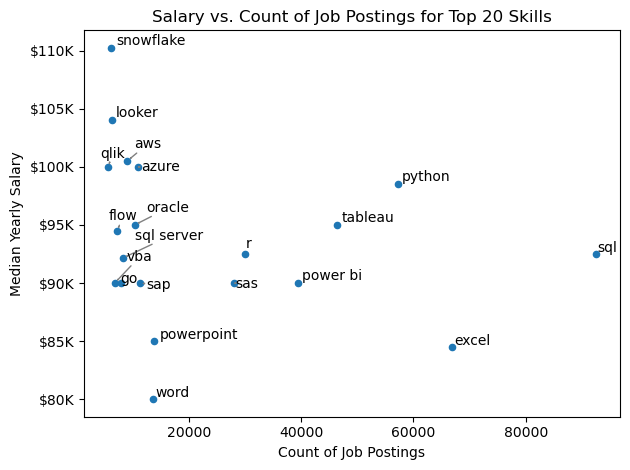

In [13]:
from adjustText import adjust_text

# Create a scatter plot:
# - x-axis = how many job postings mention the skill (skill_count)
# - y-axis = the median yearly salary for that skill (median_salary)
skill_stats.plot(kind='scatter', x='skill_count', y='median_salary')

# Create an empty list to store the text labels so we can adjust them later
texts = []

# Loop through each skill (row) in skill_stats using enumerate
# - i = row number (0, 1, 2, …)
# - txt = skill name (from the DataFrame index)
for i, txt in enumerate(skill_stats.index):
    # Add text labels for each point in the scatter plot
    # - Use .iloc[i] to get the x (skill_count) and y (median_salary) positions
    # - txt is the skill name
    # - Each plt.text() returns a text object → we save it into the list "texts"
    texts.append(
        plt.text(skill_stats['skill_count'].iloc[i], 
                 skill_stats['median_salary'].iloc[i], 
                 txt)
    )

# Use adjust_text to automatically move the labels so they don’t overlap
# - arrowprops adds arrows pointing from moved labels back to their points
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Label the x-axis
plt.xlabel('Count of Job Postings')

# Label the y-axis
plt.ylabel('Median Yearly Salary')

# Add a title with f-string to include the number of skills dynamically
plt.title(f'Salary vs. Count of Job Postings for Top {skill_count} Skills')

# Get the current Axes object (the chart area) for further customization
ax = plt.gca()

# Format the y-axis to show salaries in $K (thousands) instead of raw numbers
# Example: 80000 becomes "$80K"
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K')
)

# Adjust layout so titles, labels, and chart elements don’t overlap
plt.tight_layout()

# Show the final plot
plt.show()
